In [1]:
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('../data/playData.csv')
print(f"Shape of the dataframe: {df.shape}")
display(df.head())

Shape of the dataframe: (454011, 31)


,game_id,eventIdx,season,game_type,start_time,end_time,away_team_id,away_team_name,home_team_id,home_team_name,...,period,periodType,periodTime,periodTimeRemaining,is_goal,Assist_first,Assist_last,Scorer,Goalie,Shooter
0,2016020001,9,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,Ottawa Senators,...,1,REGULAR,01:11,18:49,0,NaN,NaN,NaN,Craig Anderson,Mitchell Marner
1,2016020001,48,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,Ottawa Senators,...,1,REGULAR,09:00,11:00,0,NaN,NaN,NaN,Frederik Andersen,Erik Karlsson
2,2016020001,97,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,Ottawa Senators,...,1,REGULAR,17:21,02:39,0,NaN,NaN,NaN,Craig Anderson,Martin Marincin
3,2016020001,137,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,Ottawa Senators,...,2,REGULAR,02:02,17:58,0,NaN,NaN,NaN,Frederik Andersen,Marc Methot
4,2016020001,161,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,Ottawa Senators,...,2,REGULAR,06:19,13:41,0,NaN,NaN,NaN,Craig Anderson,Connor Carrick


In [19]:
# Pivot tabe shotType, event, 
df_pivot = df[df.season==20182019].pivot_table(index=['shotType'], 
                          columns='event', 
                          values='eventIdx', 
                          aggfunc='count',
                          fill_value=0)
df_pivot

event,Goal,Shot
shotType,,
Backhand,792,5929
Deflected,252,1341
Slap Shot,765,11095
Snap Shot,1191,10573
Tip-In,742,3581
Wrap-around,59,790
Wrist Shot,4147,41413


In [28]:
df_pivot['Total Shots'] = df_pivot['Goal'] + df_pivot['Shot']

# Success Ratio: probability of scoring a goal if you play that shot : P(Goal|shortType)
df_pivot['Conversion Rate'] = df_pivot['Goal'] *100/ df_pivot['Total Shots']

# Goal proportion of shot type x: P(shortType|Goal)
df_pivot['Goal proportion'] = df_pivot['Goal'] *100/ df_pivot['Goal'].sum()
#df_pivot['Shot proportion'] = df_pivot['Shot'] *100/ df_pivot['Shot'].sum()

# Shot proportion of shot type x: P(shortType|Shot)
df_pivot['Shot proportion'] = df_pivot['Total Shots'] *100/ df_pivot['Total Shots'].sum()

# Expected value of scoring a goal if you play that shot: P(Goal|shortType) * P(shortType|Goal)
df_pivot['Expected value'] = (df_pivot['Conversion Rate']/100) * (df_pivot['Shot proportion']/100) *100

df_pivot['Variance'] = df_pivot['Expected value'] * (1 - df_pivot['Conversion Rate']/100)
df_pivot['Standard Deviation'] = np.sqrt(df_pivot['Variance'])
df_pivot['Reward-to-Risk Ratio'] = df_pivot['Expected value'] / df_pivot['Standard Deviation']

# Expected value of 
df_pivot

event,Goal,Shot,Total Shots,Conversion Rate,Goal proportion,Shot proportion,Expected value,Variance,Standard Deviation,Reward-to-Risk Ratio
shotType,,,,,,,,,,
Backhand,792,5929,6721,11.783961,9.964771,8.129914,0.958026,0.845132,0.919311,1.042113
Deflected,252,1341,1593,15.819209,3.170609,1.926938,0.304826,0.256605,0.506562,0.601755
Slap Shot,765,11095,11860,6.450253,9.625063,14.346196,0.925366,0.865677,0.930418,0.994570
Snap Shot,1191,10573,11764,10.124107,14.984902,14.230071,1.440668,1.294813,1.137898,1.266078
Tip-In,742,3581,4323,17.164006,9.335682,5.229225,0.897544,0.743490,0.862259,1.040923
Wrap-around,59,790,849,6.949352,0.742325,1.026975,0.071368,0.066408,0.257698,0.276944
Wrist Shot,4147,41413,45560,9.102283,52.176648,55.110681,5.016330,4.559729,2.135352,2.349181


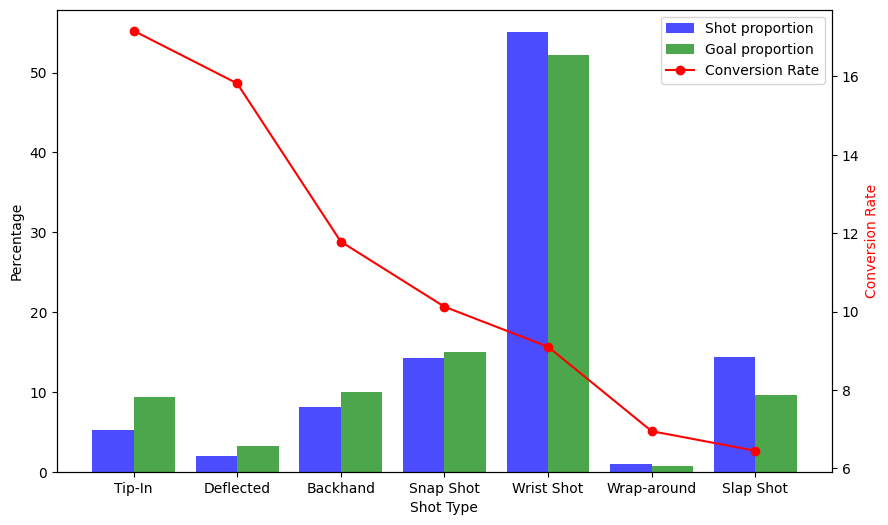

In [5]:
# Data
# sort df_pivot by Success Ratio
df_pivot = df_pivot.sort_values(by='Conversion Rate', ascending=False)

categories = df_pivot.index
bar1_data = df_pivot['Shot proportion']
bar2_data = df_pivot['Goal proportion']
line_data = df_pivot['Conversion Rate']

x = np.arange(len(categories))

# Create a figure and the first axis (for the first bar plot)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create the first bar plot on the first axis
ax1.bar(x - 0.2, bar1_data, width=0.4, color='b', alpha=0.7, label='Shot proportion')
ax1.bar(x + 0.2, bar2_data, width=0.4, color='g', alpha=0.7, label='Goal proportion')
ax1.set_xlabel('Shot Type')
ax1.set_ylabel('Percentage')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
#ax1.legend(loc='upper left')

# Create the second axis (for the line plot) sharing the same x-axis
ax2 = ax1.twinx()

# Create the line plot on the second axis
ax2.plot(x, line_data, color='r', marker='o', linestyle='-', label='Conversion Rate')
ax2.set_ylabel('Conversion Rate', color='r')

# Add a legend for the line plot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Set the title and display the plot
#plt.title('Two Bar Plots and One Line Plot with Multiple Axes')
plt.xticks(rotation=90)
plt.show()


### 1. *Shots Proportion*:
- Represents the frequency with which each type of shot is taken.
- *Interpretation*: Wrist shots have a shots proportion of 0.55, it means that 55% of all shots taken are wrist shots. This can give an insight into the most preferred or frequently used shooting techniques.

### 2. *Goals Proportion*:
- Represents the frequency of goals for each shot type out of the total goals scored.
- *Interpretation*: Wrist shots have a goals proportion of 0.51, it means that 51% of all goals scored resulted from snap shots. 

### 3. *Conversion Rate (Success Ratio)*:
- Represents the effectiveness of each shot type, or the likelihood of a shot of that type resulting in a goal.
- *Interpretation*: Wrist shots have a conversion rate of 0.09, it means that 9% of all wrist shots taken result in a goal. 

### Analysis:

1. *Identifying Effective Techniques*: 
    - A shot type with a high conversion rate is a more effective technique for scoring. Snap shots have a higher conversion rate than wrist shots, it means players are more likely to score with a snap shot than with a wrist shot when they take one.

2. *Preference vs. Effectiveness*:
    - Contrast shots proportion with conversion rate: 
        - High shots proportion but low conversion rate: Players prefer this shot type, but it might not be the most effective in scoring. For example, wrist shots are taken more often than slap shots, but they are less effective in scoring.
        
        - Low shots proportion but high conversion rate: This shot type isn't used as often but is more effective when used. This could indicate an opportunity to train players in this type of shot. For example, backhand shots are taken less often than wrist shots, but they are more effective in scoring.

3. *Impact on the Game*:
    - Compare goals proportion with conversion rate: 
        - High goals proportion and high conversion rate: This shot type is not only effective but also significantly impacts the game outcomes. Snap shot has a high goals proportion and a high conversion rate, it means that snap shots are not only effective but also frequently used in scoring.
        - High goals proportion but low shots proportion: Indicates a shot type that, while not frequently used, has a significant impact when it is used. For example, tip-in shots are not taken often, but they are effective in scoring.

4. *Strategic Insights*:
    - If a certain shot type has both a high goals proportion and a high conversion rate, teams should be defensively prepared for it like slap shots.
    - On the offensive side, if a shot type has a high conversion rate but a low shots proportion, it could be an underutilized strategy like backhand shots. Teams could train players to use this technique more often to increase their chances of scoring.

5. *Anomalies & Opportunities*:
    - Look for discrepancies: Backhand shots have a low shots proportion but a high conversion rate, it indicates that players aren't taking backhand shots often, but when they do, they tend to be effective. This could be an avenue for teams to explore and capitalize on.


### Which is the most dangerous shot type?
Just by overlaying the shots played overtop the goals scored we can see that the **Snap shot** is the most dangerous shot type. It has the highest goals proportion and conversion rate. It is also one of the most frequently used shot type. 

On a different school of thought, looking at delta of proportion one might think wrist shot to be the most dangerous but this means that teams would be defensively prepared for wrist shots. Snap shots are played less frequently, has a better conversion rate and more often than not results in a goal.

### Why this figure?
The multi-axis grouped bar-line chart perfectly encapsulates the information from shots/goals proportion and conversion rate. It also allows us to compare the shot types with each other and see the delta of proportion. The line chart allows us to see the conversion rate of each shot type and compare it with the proportion of goals scored.

## Q2

In [6]:
def euclidian_distance_goal(x_shot : int, y_shot : int,
                            period : int , home = True) -> float:
    y_goal = 0
    x_goal = 89 if x_shot > 0 else -89
    return np.linalg.norm(np.array([x_shot, y_shot]) - np.array([x_goal, y_goal]))

df['shot_distance'] = df.apply(lambda row: euclidian_distance_goal(x_shot = row['x_coordinate'], 
                                           y_shot = row['y_coordinate'], 
                                           period = row['period'],
                                           home = (row['home_team_name'] == row['team_name'])),axis=1)

In [7]:
df_pivot = df[df.season==20182019].pivot_table(index=['is_goal'],
                            columns='shotType', 
                            values='shot_distance', 
                            aggfunc='mean',
                            fill_value=0)
df_pivot

shotType,Backhand,Deflected,Slap Shot,Snap Shot,Tip-In,Wrap-around,Wrist Shot
is_goal,,,,,,,
0,20.056698,22.715200,49.344550,36.634155,18.405319,7.968945,35.310509
1,13.152606,15.206488,39.811651,25.979927,13.161015,7.816404,23.302483


In [16]:
# convert shot_distance to quantiles
df['shot_distance_quantiles'] = pd.qcut(df['shot_distance'], q=10, labels=False)
#df = df.sort_values(by='shot_distance', ascending=False)

def quantile_range(group):
    min_value = group['shot_distance'].min().round(2)
    max_value = group['shot_distance'].max().round(2)
    return f"{min_value} - {max_value}"

# Group by 'shot_distance_quantiles' and apply the quantile_range function
quantile_ranges = df.groupby('shot_distance_quantiles').apply(quantile_range)

# Map the quantile ranges to the original DataFrame
df['shot_distance_quantile_range'] = df['shot_distance_quantiles'].map(quantile_ranges)

def get_distance_goal_pivot(season):
    df_pivot = df[df.season==season].pivot_table(index=['shot_distance_quantile_range'],
                                                columns='event',
                                                values=['eventIdx'],
                                                aggfunc=['count'],
                                                fill_value=0)
    #df_pivot.columns  = df_pivot.columns.droplevel(0)
    #df_pivot.reset_index(inplace=True)
    return df_pivot
                                            

In [17]:
seasons = [20182019,20192020,20202021]
season_map = {}
for season in seasons:
    season_map[season] = get_distance_goal_pivot(season).reset_index()
    season_map[season].columns = season_map[season].columns.droplevel([0,1])
    season_map[season].columns = ['shot_distance_quantile_range','Goal','Shot']
    season_map[season]['Conversion Rate'] = season_map[season]['Goal'] *100/ (season_map[season]['Shot']+season_map[season]['Goal'])


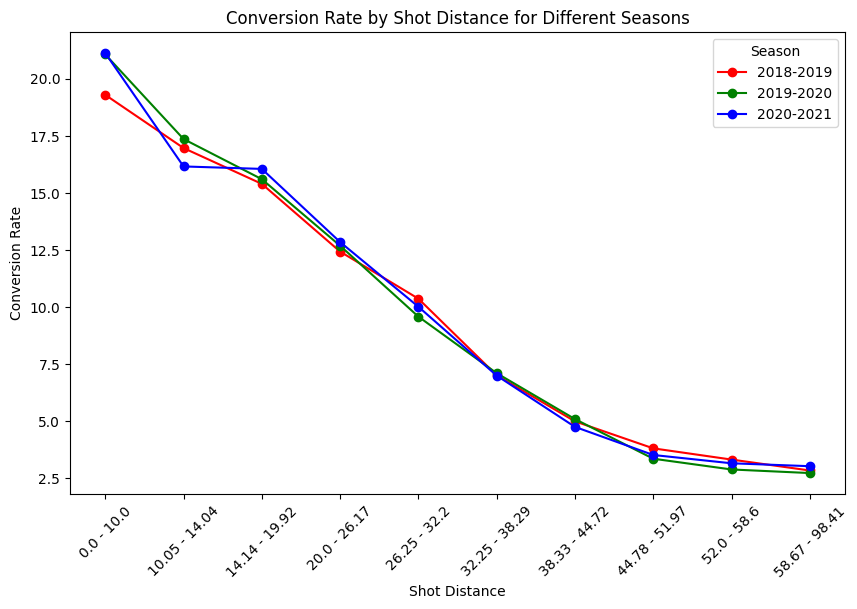

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create the line plot on the second axis
ax.plot(season_map[seasons[0]]['shot_distance_quantile_range'], 
        season_map[seasons[0]]['Conversion Rate'], color='r', marker='o', linestyle='-', label='2018-2019')
ax.plot(season_map[seasons[1]]['shot_distance_quantile_range'], 
        season_map[seasons[1]]['Conversion Rate'], color='g', marker='o', linestyle='-', label='2019-2020')
ax.plot(season_map[seasons[2]]['shot_distance_quantile_range'], 
        season_map[seasons[2]]['Conversion Rate'], color='b', marker='o', linestyle='-', label='2020-2021')
ax.set_ylabel('Conversion Rate')
ax.set_xlabel('Shot Distance')

# Add a legend for the line plot
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines,labels, title='Season',loc='upper right')

plt.xticks(rotation=45)
# Set the title and display the plot
plt.title('Conversion Rate by Shot Distance for Different Seasons')
plt.show()

### Q3

Combine the information from the previous sections to produce a figure that shows the goal percentage (# goals / # shots) as a function of both distance from the net, and the category of shot types (you can pick a single season of your choice). Briefly discuss your findings; e.g. what might be the most dangerous types of shots?

In [167]:
season_map[seasons[1]]

,shot_distance_quantile_range,Goal,Shot,Conversion Rate
0,0.0 - 10.0,1533,5745,21.063479
1,10.05 - 14.04,1159,5519,17.355496
2,14.14 - 19.92,1114,6029,15.595688
3,20.0 - 26.17,885,6095,12.679083
4,26.25 - 32.2,665,6282,9.572477
5,32.25 - 38.29,484,6339,7.093654
6,38.33 - 44.72,355,6630,5.082319
7,44.78 - 51.97,232,6703,3.345350
8,52.0 - 58.6,213,7198,2.874106
9,58.67 - 98.41,210,7520,2.716688


In [168]:
def calculate_proportion(group, column_name):
    group[column_name + '_prop'] = group[column_name] / group[column_name].sum()
    return group

# Now, apply the function
tmp = season_map[seasons[0]]
tmp = tmp.groupby(['shot_distance_quantile_range'], as_index = False).apply(calculate_proportion, column_name='Shot')
tmp = tmp.groupby(['shot_distance_quantile_range'], as_index = False).apply(calculate_proportion, column_name='Goal')

tmp = tmp.fillna(0)

tmp = tmp.droplevel([0, 1])

#tmp = tmp.reset_index()

In [169]:
tmp

,index,shot_distance_quantile_range,Goal,Shot,Conversion Rate,Shot_prop,Goal_prop
0,0,0.0 - 10.0,1557,6514,19.291290,1.0,1.0
1,1,10.05 - 14.04,1424,6972,16.960457,1.0,1.0
2,2,14.14 - 19.92,1298,7136,15.390088,1.0,1.0
3,3,20.0 - 26.17,1019,7184,12.422285,1.0,1.0
4,4,26.25 - 32.2,835,7226,10.358516,1.0,1.0
5,5,32.25 - 38.29,578,7678,7.000969,1.0,1.0
6,6,38.33 - 44.72,418,7970,4.983309,1.0,1.0
7,7,44.78 - 51.97,311,7874,3.799633,1.0,1.0
8,8,52.0 - 58.6,270,7892,3.308013,1.0,1.0
9,9,58.67 - 98.41,241,8277,2.829303,1.0,1.0
